In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots
from datetime import datetime, timedelta

dataset_max_date  = pd.Timestamp('01-Mar-2006')
dataset_min_date = pd.Timestamp(dataset_max_date - timedelta(days = 30))




%store -r WORKDIR

if 'WORKDIR' not in dir():
    WORKDIR = 'C:/Users/thewr/git/mit_data_science.git/'
               


data_proc_file = WORKDIR + '/Data/Processed/energy_consumption_data_modeling.parquet'
model_score_file = WORKDIR + '/Data/Modeling/model_scores.parquet'
model_file = WORKDIR + '/Data/Modeling/trained_models.jbl'
model_forecasting_versus_actuals_file = WORKDIR + '/Data/Modeling/forecasting_versus_actuals.parquet'

# Leitura dos Dados 

In [2]:
pjme = pd.read_parquet(data_proc_file)

print('shape:', pjme.shape)
print('columns:', pjme.columns)

shape: (8710, 2)
columns: Index(['Datetime', 'PJME_MW'], dtype='object')


In [3]:
pjme_full_historic_data = pjme

In [4]:
pjme.set_index('Datetime', inplace=True)

In [5]:
pjme = pjme[dataset_min_date:dataset_max_date]

print('shape:', pjme.shape)
print('columns:', pjme.columns)

shape: (721, 1)
columns: Index(['PJME_MW'], dtype='object')


In [6]:
pjme.head()

PJME_MW
Datetime                    
2006-01-30 00:00:00  27036.0
2006-01-30 01:00:00  25492.0
2006-01-30 02:00:00  24676.0
2006-01-30 03:00:00  24464.0
2006-01-30 04:00:00  24668.0

In [7]:
pjme.tail()

PJME_MW
Datetime                    
2006-02-28 20:00:00  39916.0
2006-02-28 21:00:00  39114.0
2006-02-28 22:00:00  37417.0
2006-02-28 23:00:00  34691.0
2006-03-01 00:00:00  31950.0

In [8]:
pjme.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 721 entries, 2006-01-30 00:00:00 to 2006-03-01 00:00:00
Data columns (total 1 columns):
PJME_MW    721 non-null float64
dtypes: float64(1)
memory usage: 11.3 KB


In [9]:
pd.plotting.register_matplotlib_converters()

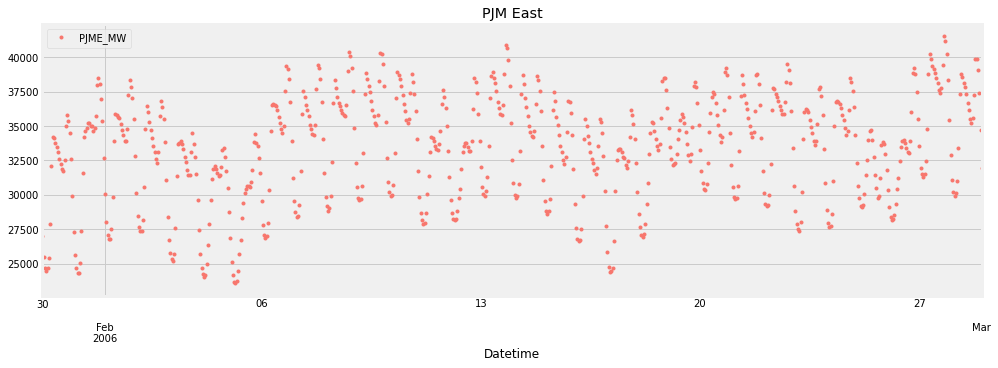

In [10]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
pjme.loc[pjme.index].plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')
plt.show()

In [11]:
with open(model_file, 'rb') as fid:
    trained_models = pickle.load(fid)

In [12]:
df_models = pd.read_parquet(model_score_file) 
df_models.head()

model_name date_begin   date_end     score
0    prophet 2006-01-30 2006-03-01  3.563124

In [13]:
model = trained_models

In [14]:
model_last_date = df_models.date_end.dt.date.values[0] 

In [15]:
print(model_last_date)

2006-03-01


In [16]:
#date_max = 1.5 years after model_last_date
forecast_days = 5
date_max = model_last_date + timedelta(forecast_days)
n_periods = 24*forecast_days


In [17]:
print(model)

forecast_data = model.make_future_dataframe(periods=n_periods, freq='h',include_history=False)

In [18]:
forecast_data = model.make_future_dataframe(periods=n_periods, freq='h',include_history=False)

RecursionError: maximum recursion depth exceeded while calling a Python object

In [ ]:
print(n_periods)

In [19]:
#forecast_data = model.make_future_dataframe(periods=n_periods, freq='h',include_history=False)

In [20]:
forecast_data.shape

NameError: name 'forecast_data' is not defined

In [21]:
forecast_data.ds.max()

NameError: name 'forecast_data' is not defined

In [ ]:
forecast_data.head()

In [ ]:
forecast_data.tail()

In [ ]:
# Predict on training set with model
df_forecast= model.predict(forecast_data).rename(columns={'Datetime':'ds'})

In [ ]:
df_forecast.tail()

In [ ]:
df_forecast.set_index('ds')

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme[model_last_date:date_max].index, pjme[model_last_date:date_max]['PJME_MW'], color='r')
fig = model.plot(df_forecast, ax=ax)

In [ ]:
month_lower_date = pd.Timestamp(model_last_date)
month_upper_date = pd.Timestamp(model_last_date + timedelta(days = 5))

week_lower_date = pd.Timestamp(model_last_date)
week_upper_date = pd.Timestamp(model_last_date + timedelta(days = 1))

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme[model_last_date:date_max].index, pjme[model_last_date:date_max]['PJME_MW'], color='r')
fig = model.plot(df_forecast, ax=ax)
ax.set_xbound(lower=month_lower_date,
              upper=month_upper_date)
ax.set_ylim(0, 60000)
plot = plt.suptitle('Forecast vs Actuals - 30 days')

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme[model_last_date+timedelta(days=1):date_max].index, pjme[model_last_date+timedelta(days=1):date_max]['PJME_MW'], color='r')
fig = model.plot(df_forecast, ax=ax)
ax.set_xbound(lower=week_lower_date,
              upper=week_upper_date)
ax.set_ylim(0, 60000)
plot = plt.suptitle('Forecast vs Actuals - 7 days')

In [ ]:
pjme = pjme.reset_index()

In [ ]:
forecast = df_forecast[['ds','yhat']].reset_index().rename(columns={'yhat':'forecast'})

In [ ]:
forecast.head()

In [ ]:
pjme_full_historic_data.head()

In [ ]:
pjme_full_historic_data= pjme_full_historic_data[pjme_full_historic_data.index > pd.Timestamp('2006-03-01')]

In [ ]:
pjme_full_historic_data.head()

In [ ]:
actualdata_forecast_error = pd.merge(pjme_full_historic_data, forecast, how='inner', \
        left_on='Datetime', right_on='ds')

In [ ]:
actualdata_forecast_error.head()

In [ ]:
actualdata_forecast_error.isnull().sum()

In [ ]:
actualdata_forecast_error['error'] = actualdata_forecast_error['PJME_MW'] -  actualdata_forecast_error['forecast']

In [ ]:
actualdata_forecast_error['percentage_error'] = (actualdata_forecast_error['error']/actualdata_forecast_error['PJME_MW'])*100

In [ ]:
actualdata_forecast_error.isnull().sum()

In [ ]:
actualdata_forecast_error.shape

# Error Metrics
Our RMSE error is 15987910.88
Our MAE error is 3247.98
Our MAPE error is 10.344

by comparison in the XGBoost model our errors were significantly less (8.9% MAPE): Check that out here

In [ ]:
mean_squared_error(y_true=actualdata_forecast_error['PJME_MW'],
                   y_pred=actualdata_forecast_error['forecast'])

In [ ]:
mean_absolute_error(y_true=actualdata_forecast_error['PJME_MW'],
                   y_pred=actualdata_forecast_error['forecast'])

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

score = mean_absolute_percentage_error(y_true=actualdata_forecast_error['PJME_MW'],
                   y_pred=actualdata_forecast_error['forecast'])

In [ ]:
print(score)

In [ ]:
actualdata_forecast_error.head()

In [ ]:
actualdata_forecast_error.round(1)

In [ ]:
actualdata_forecast_error.head()

In [ ]:
actualdata_forecast_error.to_parquet(model_forecasting_versus_actuals_file)